# Higgs EFT Decomposed Likelihood Ratios

J. Pavez

In this notebook I will show how to use decomposed likelihood ratios to compute the couplings coefficients for Higgs VBF data. For this, two bases of 15 samples are used. The bases are computed using the code on [pyMorphWrapper](./pyMorphWrapper.py) an example of how to use the morphing code can be found [here](./Higgs EFT decomposed likelihoods.ipynb). 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import theano

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [4]:
# coupling values for each sample
theta = [[1.0, -0.5, -0.5], 
         [1.0, -0.5, 0.5], 
         [1.0, -0.35714285714285715, -0.071428571428571452], 
         [1.0, -0.35714285714285715, 0.21428571428571419], 
         [1.0, -0.2142857142857143, -0.2142857142857143], 
         [1.0, -0.2142857142857143, 0.071428571428571397], 
         [1.0, -0.2142857142857143, 0.3571428571428571], 
         [1.0, -0.071428571428571452, -0.35714285714285715], 
         [1.0, -0.071428571428571452, -0.071428571428571452], 
         [1.0, -0.071428571428571452, 0.21428571428571419], 
         [1.0, 0.21428571428571419, -0.2142857142857143], 
         [1.0, 0.21428571428571419, 0.071428571428571397], 
         [1.0, 0.3571428571428571, 0.5], 
         [1.0, 0.5, -0.071428571428571452], 
         [1.0, 0.5, 0.21428571428571419],
         [1.0, -0.5, -0.35714285714285715], 
         [1.0, -0.5, -0.071428571428571452], 
         [1.0, -0.5, 0.3571428571428571], 
         [1.0, -0.2142857142857143, -0.071428571428571452], 
         [1.0, -0.2142857142857143, 0.21428571428571419], 
         [1.0, -0.2142857142857143, 0.5], 
         [1.0, -0.071428571428571452, -0.5], 
         [1.0, -0.071428571428571452, -0.2142857142857143], 
         [1.0, -0.071428571428571452, 0.071428571428571397], 
         [1.0, 0.071428571428571397, -0.071428571428571452], 
         [1.0, 0.071428571428571397, 0.3571428571428571], 
         [1.0, 0.21428571428571419, -0.35714285714285715], 
         [1.0, 0.21428571428571419, 0.21428571428571419], 
         [1.0, 0.5, -0.2142857142857143], 
         [1.0, 0.5, 0.5]]

theta = np.array(theta)

# Bases
theta_0 = theta[:15]
theta_1 = theta[15:]
bases = [range(15),range(15,30)]

# Sample to fit
F1 = [1.0, 0.0, 0.0]
#F1 = [1.0, -0.071428571428571452, -0.071428571428571452]
observed = 30

#F1 = [1., -0.2142857142857143, -0.2142857142857143]
#observed = '4'

F0 = theta_0[0]

# Variables used in the data
feature_names = ["minDelR_jZ", "DelPhi_Hjj", "DelEta_Hjj", "DelPhi_jj", "DelR_jj", 
                 "DelY_jj", "Mjj", "DelPt_jj", "DelPt_ZZ", "pT_Hjj", "Mjets", "Zeppetaj3", 
                 "ZeppetaZZ", "njets","Z1_E","Z1_pt","Z1_eta","Z1_phi","Z1_m","Z2_E","Z2_pt",
                 "Z2_eta","Z2_phi","Z2_m",  "higgs_E","higgs_pt","higgs_eta","higgs_phi","higgs_m", 
                 "jet1_E","jet1_eta","jet1_y","jet1_phi","jet1_pt","jet1_m","jet2_E", "jet2_eta","jet2_y", 
                 "jet2_phi","jet2_pt","jet2_m","jet3_E","jet3_eta","jet3_y" ,"jet3_phi","jet3_pt","jet3_m"]

#subset = list(range(1,len(feature_names)))
#subset = [33,3]
subset = [3, 4, 6, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 30, 33, 34, 36, 39, 40]

data_F0 = 8

#c_min = [-0.3557, -0.34467]
#c_max = [0.2646, 0.34467]
# Fitting space
c_min = [-0.6, -0.6]
c_max = [0.6, 0.6]
npoints = 20 # Number of values in the fitting grid

n_samples = 90000*len(theta) # Number Training + calibration samples
test_samples = 25000 # Number fitting samples

csarray_0 = np.linspace(c_min[0], c_max[0], npoints)
csarray_1 = np.linspace(c_min[1], c_max[1], npoints)
# Change this to you own data folder
base_dir = "/afs/cern.ch/work/j/jpavezse/private/data/full_data/"

In [5]:
np.random.seed(1234)

X_observed = np.loadtxt(base_dir + "data_%d.dat" 
                        % observed)[:, subset] # Fitting data

X_observed.shape

(608761, 19)

Defining the mixture models used in carl. This is a workaround in order to use carl's DecomposedTest. The mixture model represent the weighted sum of samples where each weight is dependant on the coupling values

In [6]:
# Mixture Model definition
class Component:
    # Component is each sample
    def __init__(self, base):
        self.data = np.loadtxt("%sdata_%d.dat" % (base_dir,base))[:n_samples//len(theta), subset]
    def rvs(self, n_samples, random_state=1234):
        #n_samples = n_samples if n_samples < len(self.data) else len(self.data)
        #return self.data[:n_samples]
        return self.data
class Mixture:
    # Mixture is the sum of samples using weights and cross section    
    def __init__(self, basis, couplings, cross_sections):
        self.basis = basis
        self.couplings = couplings
        self.cross_sections = cross_sections
        self.components = []
        for base in self.basis:
            self.components.append(Component(base))
    
    def compute_weights(self,**kwargs):
        couplings = np.array(map(lambda x: x.eval(),self.couplings))
        cross_sections = np.array(map(lambda x: x.eval(), self.cross_sections))
        cs = np.multiply(couplings, cross_sections)
        return cs / cs.sum()        


Reading coupling and cross section values for each one of the bases and for each one of the parameter values on the grid. If values were computed before then they are re-used. Otherwise values are computed and saved.

In [7]:
from pyMorphWrapper import MorphingWrapper

In [8]:
# Compute bases if they don't exist for this range
if not os.path.isfile(
    'doubleindexes_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0],
        c_min[1],
        c_max[0],
        c_max[1],
        npoints)):

    morph = MorphingWrapper()

    morph.setSampleData(nsamples=15, ncouplings=3, types=['S','S','S'], morphed=F1, samples=theta)

    morph.pre2DDoubleBasis(c_min=c_min, c_max=c_max, npoints=npoints,
                         indexes=bases)

In [9]:
# Reading indexes, couplings and cross_sections
all_indexes = np.loadtxt(
    'doubleindexes_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))
all_indexes = np.array([[int(x) for x in rows]
                        for rows in all_indexes])
all_couplings = np.loadtxt(
    'doublecouplings_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))
all_cross_sections = np.loadtxt(
    'doublecrosssection_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))

Defining shared variables for each of the coupling parameters.

In [10]:
# Define Mixture Models
base_mixtures = []
couplings = []
cross_sections = []
for b, indexes in enumerate(all_indexes):
    couplings.append([theano.shared(0.,name='w_{0}_{1}'.format(b,k)) for k in range(len(indexes))])
    cross_sections.append([theano.shared(0.,name='cx_{0}_{1}'.format(b,k)) for k in range(len(indexes))])
    base_mixtures.append(Mixture(indexes, couplings[b], cross_sections[b]))

Defining the denominator to be used on the likelihood decomposition formula. In theory the sample choosed as denominator should not affect the final result 

In [22]:
# For denominator using just the first component
den_indexes = [data_F0]
den_couplings = [theano.shared(1.,name='w_den')]
den_cross_sections = [theano.shared(1., name='cx_den')]
den_mixture = Mixture(den_indexes, den_couplings, den_cross_sections)

In [23]:
decomposedLikelihood = np.zeros((npoints, npoints))
n_effs = np.zeros((npoints, npoints))
alphas = np.zeros((2, npoints, npoints))
ratiosList = []

Defining the classifier and calibration strategy used to approximate the likelihood ratio. 

In [24]:
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit

from xgboost_wrapper import XGBoostClassifier

def make_ratio(num, den):
    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=15, random_state=0, n_jobs=-1)
    #clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
    #clf = XGBoostClassifier(missing=-999., num_class=2, nthread=4, silent=0, num_boost_round=100, eta=0.3,
    #        max_depth=6)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = DecomposedRatio(ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=30, method='histogram'),
        random_state=0))
    ratio.fit(numerator=num, denominator=den, n_samples=n_samples)
    
    return ratio

In [25]:
base_ratios = []
base_ratios.append(make_ratio(base_mixtures[0],den_mixture))
base_ratios.append(make_ratio(base_mixtures[1],den_mixture))

These functions are used to weight each base when evaluating the likelihood on the parameters grid. The idea 
is that by using a weighted sum of bases a better and smoother n_eff can be obtained.

In [26]:
def get_weights(w):
    n_tot = np.abs(w).sum()
    n_eff = w.sum()
    n_eff = n_eff / n_tot
    alpha = np.exp(-np.sqrt(1./n_eff))
    #alpha1 = np.exp(-neff1**(1./3.))
    return alpha, n_eff
def get_alpha(w,cx):
    c = np.multiply(w, cx)
    n_tot = np.abs(c).sum()
    n_eff = c.sum()
    n_eff = n_eff / n_tot
    alpha = np.multiply(w**2,cx)
    return alpha.sum(), n_eff


Main loop to compute the likelihood on the grid of values. At each point the values of the shared variables for each coupling are set. Then the negative log likelihood ratio is computed. 

In [39]:
np.random.seed(111)
indexes = np.random.choice(X_observed.shape[0], test_samples, replace=False)
X_observed_sub = X_observed[indexes]
#X_observed_sub = X_observed[10000:15000]

zeros = np.zeros((npoints,npoints))
#cross_sections = zeros((npoints,npoints))

target = [1.,0.,0.]
def optimize(X_obs):
    for i, cs_0 in enumerate(csarray_0):
        for j, cs_1 in enumerate(csarray_1):
            target[1] = cs_0
            target[2] = cs_1
            #print '{0} {1}'.format(i, j)
            #print target

            # Compute F1 couplings and cross sections
            cs_b0 = all_couplings[i * npoints + j]
            cross_section_b0 = all_cross_sections[i * npoints + j]  
        
            map(lambda (var, val): var.set_value(val), zip(couplings[0],cs_b0))
            map(lambda (var, val): var.set_value(val), zip(cross_sections[0],cross_section_b0))

            cs_b1 = all_couplings[npoints * npoints + i * npoints + j]
            cross_section_b1 = all_cross_sections[npoints * npoints + i * npoints + j]
            map(lambda (var, val): var.set_value(val), zip(couplings[1],cs_b1))
            map(lambda (var, val): var.set_value(val), zip(cross_sections[1],cross_section_b1))
            # Compute ratios
            ratio_0 = base_ratios[0]
            ratio_1 = base_ratios[1]
            # Compute weights for each ratio
            w_0 = np.multiply(cs_b0, cross_section_b0)        
            w_1 = np.multiply(cs_b1, cross_section_b1)

            alpha_0, n_eff_0 = get_weights(w_0)
            alpha_1, n_eff_1 = get_weights(w_1)
            alphas[0,i,j] = alpha_0 / (alpha_0 + alpha_1)
            alphas[1,i,j] = alpha_1 / (alpha_0 + alpha_1)

            #alpha_0, n_eff_0 = get_alpha(cs_b0, cross_section_b0)
            #alpha_1, n_eff_1 = get_alpha(cs_b1, cross_section_b1)
            #alphas[0,i,j] = (1/2.)*(alpha_1/(alpha_1+alpha_0))
            #alphas[1,i,j] = (1/2.)*(alpha_0/(alpha_1+alpha_0))

            n_effs[i,j] = alphas[0,i,j]*n_eff_0 + alphas[1,i,j]*n_eff_1

            # Check ratios for negative of non defined values
            r_0 = ratio_0.predict(X_obs, keep_values=True)
            r_1 = ratio_1.predict(X_obs, keep_values=True)
            z_0 = r_0[np.isinf(r_0)].shape[0]
            z_1 = r_1[np.isinf(r_1)].shape[0]
            #print(z_0,z_1)
            r_0[np.isinf(r_0)] = 0. # Not sure about this
            r_1[np.isinf(r_1)] = 0.

            # ratio weighting
            ratio = alphas[0,i,j] * r_0 + alphas[1,i,j] * r_1
            #print(z_0,z_1,ratio[ratio < 0.].shape)
            zeros[i,j] = ratio[ratio <= 0.].shape[0]
            ratio = ratio[ratio > 0.]
            decomposedLikelihood[i,j] = -np.log(ratio).sum()
            #print(decomposedLikelihood[i,j])
    decMin = np.unravel_index(
    decomposedLikelihood.argmin(),
    decomposedLikelihood.shape)
    mle = [csarray_0[decMin[0]],csarray_1[decMin[1]]]
    return mle
print(optimize(X_observed_sub))
print('Done')

[0.03157894736842104, 0.03157894736842104]
Done


In [40]:
decomposedLikelihood *= 19.2 / test_samples

Plotting $-2ln\Lambda(x)$ values on the grid of points.

(20, 20)
-706.247151851
Min: 0.0315789473684 0.0315789473684


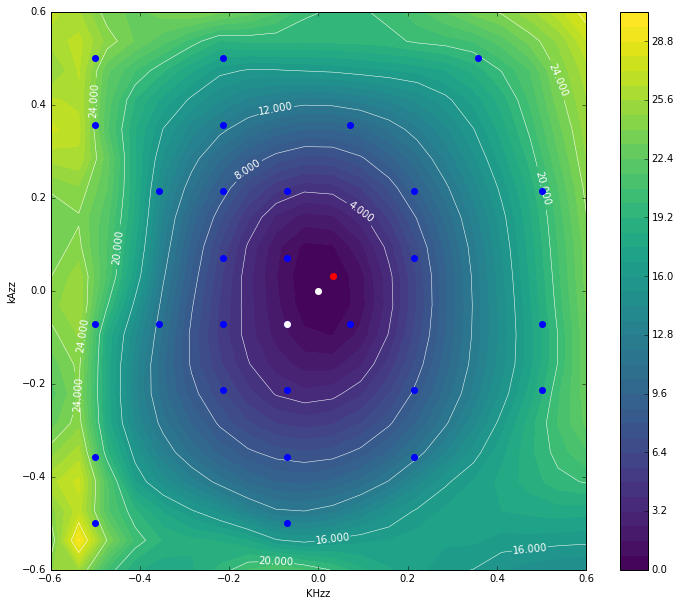

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)
from itertools import product

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([x for x in product(csarray_0, csarray_1)])

xi = csarray_0    
yi = csarray_1
xx, yy = np.meshgrid(xi, yi)
print(xx.shape)
#zi = 2.*decomposedLikelihood
#zi = zi - zi.min()
zi = decomposedLikelihood.copy()
print(zi.min())
zi -= zi.min()
zi *= 2.
zi = zi.transpose()

decMin = np.unravel_index(
    decomposedLikelihood.argmin(),
    decomposedLikelihood.shape)
mle = [csarray_0[decMin[0]],csarray_1[decMin[1]]]
print('Min: {0} {1}'.format(csarray_0[decMin[0]],csarray_1[decMin[1]]))


#cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contour(xi, yi, zi, 8, linewidths=0.5, colors='w')
plt.clabel(cs, inline=1, fontsize=10)
cs = plt.contourf(xi, yi, zi, 40, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clim(0.,16.)
#v = np.linspace(0.,16.,16)
#plt.colorbar(ticks=v)
plt.colorbar()
plt.scatter(theta[:29, 1], theta[:29, 2], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter(mle[0], mle[1], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([theta[data_F0, 1]], [theta[data_F0, 2]], marker='o', c='w', s=50, lw=0, zorder=10)

plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

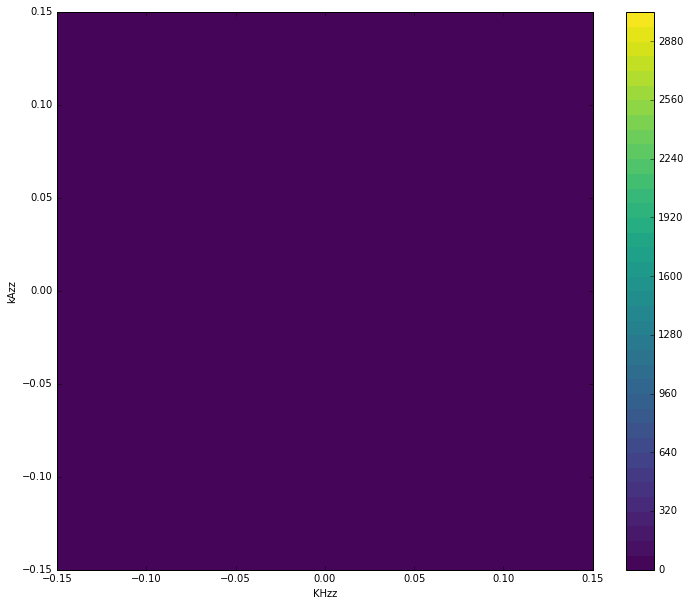

In [57]:
import pdb
thetas = np.array([x for x in product(csarray_0, csarray_1)])

xi = csarray_0    
yi = csarray_1
xx, yy = np.meshgrid(xi, yi)
zi = zeros
zi = zi.transpose()

plt.clabel(cs, inline=1, fontsize=10)
cs = plt.contourf(xi, yi, zi, 40, cmap="viridis")
plt.colorbar()  
#plt.scatter(mle[0], mle[1], marker='o', c='r', s=50, lw=0, zorder=10)
#plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)

plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

Using regression on the likelihood ratio values in order to obtain a smoother result.

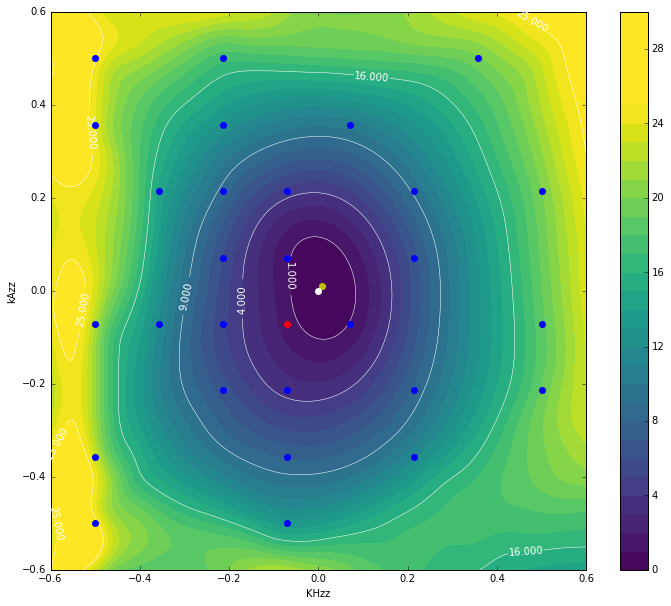

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)
from itertools import product

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([x for x in product(csarray_0, csarray_1)])
llr = decomposedLikelihood.flatten()
#mle = np.argmin(llr)
#llr -= llr[mle]
#llr *= 2.
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(-0.6, 0.6, 500)
yi = np.linspace(-0.6, 0.6, 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
#mle = [xx[mle[0]],yy[mle[1]]]
#cs = plt.contour(xi, yi, zi, 8, linewidths=0.5, colors='w')
cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, inline=1, fontsize=10)
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.clim(0.,25.)
#v = np.linspace(0.,16.,16)
#plt.colorbar(ticks=v)
plt.colorbar()
#plt.colorbar(boundaries=np.linspace(0, 25., 500))
plt.scatter(theta[:29, 1], theta[:29, 2], marker='o', c='b', s=50, lw=0, zorder=10)
#plt.scatter([theta[mle, 1]], [theta[mle, 2]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[0]]], [yi[mle[1]]], marker='o', c='y', s=50, lw=0, zorder=10)
plt.scatter([theta[data_F0, 1]], [theta[data_F0, 2]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)

plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

Plotting the n_eff values obtained using the weighted morphing.

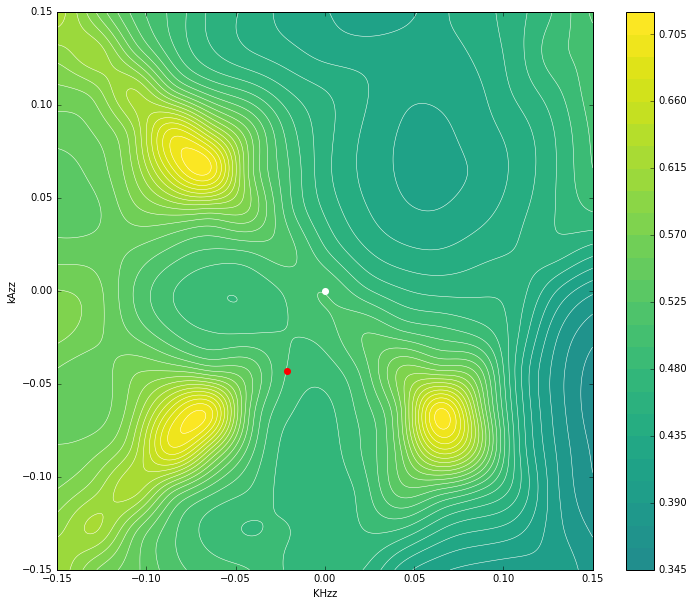

In [105]:
thetas = np.array([x for x in product(csarray_0, csarray_1)])
llr = n_effs.flatten()
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(-0.15, 0.15, 500)
yi = np.linspace(-0.15, 0.15, 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.colorbar()  
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([thetas[mle, 0]], [thetas[mle, 1]], marker='o', c='r', s=50, lw=0, zorder=10)
#plt.xlim(c_min[0], c_max[0])
#plt.ylim(c_min[1], c_max[1])
plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

In [32]:
np.savetxt('dec_sm_{0}var_den{1}.txt'.format(X_observed.shape[1],theta1), decomposedLikelihood)

# Ensemble analysis

In [ ]:
from GPyOpt.methods import BayesianOptimization
from scipy.optimize import minimize
from scipy.stats import chi2



test_samples = 500
approx_mles = []

n_hist = 150

for k in range(n_hist):
    #np.random.seed(1111)
    base_ratios[0].saved_values_ = {}
    base_ratios[1].saved_values_ = {}

    indexes = np.random.choice(X_observed.shape[0], test_samples, replace=False)
    X_observed_sub = X_observed[indexes]

    gp_MLE = optimize(X_observed_sub)

    #print("{0} GP MLE = {1}".format(k,gp_MLE))
    approx_mles.append(gp_MLE)
    
    #solver.plot_acquisition(filename='acquisition_plot.pdf')
    #solver.plot_convergence(filename='convergence_plot.pdf')
    #print("Approx. MLE =", approx_MLE)

In [ ]:
#approx_mles = np.array(approx_mles)
print(approx_mles.shape)

In [ ]:
plt.subplot(211)
h0 = plt.hist(approx_mles[:,0], range=(c_min[0],c_max[0]), bins=12, normed=1, 
             alpha=0.5, color="b", label="Approx. MLEs")
plt.vlines(F1[1], 0, h0[0].max()+5, linestyles="dashed", label=r"$kHzz = 0.$")
plt.title('kHzz')
plt.legend()
plt.subplot(212)
h1 = plt.hist(approx_mles[:,1], range=(c_min[0],c_max[0]), bins=12, normed=1, 
             alpha=0.5, color="b", label="Approx. MLEs")
plt.vlines(F1[2], 0, h1[0].max()+5, linestyles="dashed", label=r"$kAzz = 0.$")
plt.title('kAzz')
plt.legend()
#plt.savefig("fig2a.pdf")
plt.show()

## Bayesian optimization

In [ ]:
morph = MorphingWrapper()

morph.setSampleData(nsamples=15,ncouplings=3,types=['S','S','S'], ncomb=19, morphed=F1, 
                    samples=theta)

In [ ]:
def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))

        for i, x_i in enumerate(X):
            v[i] = func(x_i)

        return v.reshape(-1, 1)

    return wrapper


In [ ]:
base_ratios = []
base_ratios.append(make_ratio(base_mixtures[0],den_mixture))
base_ratios.append(make_ratio(base_mixtures[1],den_mixture))

In [ ]:
def objective(target_value):
    
    target[1] = target_value[0]
    target[2] = target_value[1]
    #print(target_value)
    morph.resetTarget(target)          
    couplings = []
    cross_sections = []
    alphas = np.zeros(2)
    # Compute couplings and cross section values
    for l,ind in enumerate(all_indexes):
        ind = np.array(ind)
        morph.resetBasis([theta[int(k)] for k in ind])
        coupling = np.array(morph.getWeights())
        cross_section = np.array(morph.getCrossSections())
        couplings.append(coupling)
        cross_sections.append(cross_section)
    
    cs_b0, cs_b1 = couplings[0],couplings[1]
    cross_section_b0, cross_section_b1 = cross_sections[0],cross_sections[1]
    # Compute ratios
    ratio_0 = base_ratios[0]
    ratio_1 = base_ratios[1]
    # Compute weights for each ratio
    w_0 = np.multiply(cs_b0, cross_section_b0)        
    w_1 = np.multiply(cs_b1, cross_section_b1)
    
    alpha_0, n_eff_0 = get_weights(w_0)
    alpha_1, n_eff_1 = get_weights(w_1)
    n_alpha_0 = alpha_0 / (alpha_0 + alpha_1)
    n_alpha_1 = alpha_1 / (alpha_0 + alpha_1)
    
    #alpha_0, n_eff_0 = get_alpha(cs_b0, cross_section_b0)
    #alpha_1, n_eff_1 = get_alpha(cs_b1, cross_section_b1)
    #alphas[0,i,j] = (1/2.)*(alpha_1/(alpha_1+alpha_0))
    #alphas[1,i,j] = (1/2.)*(alpha_0/(alpha_1+alpha_0))

    # Check ratios for negative of non defined values
    r_0 = ratio_0.predict(X_observed_sub, keep_values=True)
    r_1 = ratio_1.predict(X_observed_sub, keep_values=True)
    z_0 = r_0[np.isinf(r_0)].shape[0]
    z_1 = r_1[np.isinf(r_1)].shape[0]
    #print(z_0,z_1)
    r_0[np.isinf(r_0)] = 0. # Not sure about this
    r_1[np.isinf(r_1)] = 0.

    # ratio weighting
    ratio = n_alpha_0 * r_0 + n_alpha_1 * r_1
    #print(z_0,z_1,ratio[ratio < 0.].shape)
    print('{0}' .format(ratio[ratio < 0.].shape[0])),
    ratio = ratio[ratio > 0.]
    decomposedLikelihood = -np.log(ratio).sum()
    #print(decomposedLikelihood)
    return decomposedLikelihood


In [ ]:
from GPyOpt.methods import BayesianOptimization
from scipy.optimize import minimize
from scipy.stats import chi2

test_samples = 5000
approx_mles = []

n_hist = 50
bounds = [(c_min[0],c_max[0]),(c_min[1],c_max[1])]

solver = BayesianOptimization(vectorize(objective), bounds)

# Minimize the surrogate GP approximate of the approximate LR

for k in range(n_hist):
    #np.random.seed(1111)
    indexes = np.random.choice(X_observed.shape[0], test_samples, replace=False)
    X_observed_sub = X_observed[indexes]

    solver.run_optimization(max_iter=50, true_gradients=False)
    approx_MLE = solver.x_opt
    gp_MLE = approx_MLE
    def gp_objective(val):
        val = val.reshape(1, -1)
        return solver.model.predict(val)[0][0]

    r = minimize(gp_objective, x0=[0.5, -0.5])
    gp_MLE = r.x

    print("{0} GP MLE = {1}".format(k,gp_MLE))
    approx_mles.append(gp_MLE)
    
    #solver.plot_acquisition(filename='acquisition_plot.pdf')
    #solver.plot_convergence(filename='convergence_plot.pdf')
    #print("Approx. MLE =", approx_MLE)